In [3]:
import requests
from bs4 import BeautifulSoup as bs
import csv
import re
import networkx as nx
from tqdm import tqdm
import networkx as nx
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
plt.ioff()
import sys
sys.path.append('../d3networkx/')
#import d3networkx as d3nx
#from d3graph import D3Graph, D3DiGraph
import asyncio
import pandas as pd

from pyvis.network import Network
import numpy
import copy
import networkx.algorithms.community as nx_comm
import community
from itertools import combinations

In [45]:

def data_to_csv(data,season):
    keys = data[0].keys()
    with open(season+'.csv', 'w', newline='')  as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(data)

def format_text(text):
    regex = re.compile(r'[\n\r\t]')
    text = regex.sub('', text)
    return " ".join(text.split())

In [47]:
def get_data(pages, season):
    player_raw =[]
    for page in range(1, pages+1):
        headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36"}

        url  = f'https://www.transfermarkt.com/transfers/saisontransfers/statistik/top/saison_id/{season}/transferfenster/alle/land_id//ausrichtung//spielerposition_id//altersklasse//leihe//plus/1/galerie/0/page/{page}'
        print('scraping')
        print(url)

        html = requests.get(url, headers=headers)
        soup = bs(html.content)

        soup = soup.select('.responsive-table > .grid-view > .items > tbody')[0]
        
        for cells in soup.find_all(True, {"class": re.compile("^(even|odd)$")}):
            for ha in cells.find_all(True, {"class": re.compile("^(hauptlink)$")}):
                for a_tags in ha.find_all("a"):
                    player_raw.append(a_tags.text)

    return player_raw
        
    

def form_player(data):
    player_list=[]
    for index, x in enumerate(data):
    
        if index % 3 ==0:
            name = x
        
        if index % 3 == 1:
            team_from = x
            
        if index %3 == 2:
            team_to =x
        
            player = {
            'name': name,
            'club_from': team_from,
            'club_to': team_to,
            }
            #print(player)
            player_list.append(player)
   
    #print(player_list)
    return player_list




scraping
https://www.transfermarkt.com/transfers/saisontransfers/statistik/top/saison_id/2018/transferfenster/alle/land_id//ausrichtung//spielerposition_id//altersklasse//leihe//plus/1/galerie/0/page/1
scraping
https://www.transfermarkt.com/transfers/saisontransfers/statistik/top/saison_id/2018/transferfenster/alle/land_id//ausrichtung//spielerposition_id//altersklasse//leihe//plus/1/galerie/0/page/2
scraping
https://www.transfermarkt.com/transfers/saisontransfers/statistik/top/saison_id/2018/transferfenster/alle/land_id//ausrichtung//spielerposition_id//altersklasse//leihe//plus/1/galerie/0/page/3
scraping
https://www.transfermarkt.com/transfers/saisontransfers/statistik/top/saison_id/2018/transferfenster/alle/land_id//ausrichtung//spielerposition_id//altersklasse//leihe//plus/1/galerie/0/page/4
scraping
https://www.transfermarkt.com/transfers/saisontransfers/statistik/top/saison_id/2018/transferfenster/alle/land_id//ausrichtung//spielerposition_id//altersklasse//leihe//plus/1/galerie

In [ ]:
season_analyzed = ['2018','2019', '2020','2021']  
#season_analyzed = ['2018']
for season in season_analyzed:
    data = get_data(25, season)
    data= form_player(data)
    data_to_csv(data, season)

In [4]:
G = nx.DiGraph()
with open('./2020.csv', 'r') as f:
    data = csv.reader(f)
    headers = next(data)
    for row in data:
        if not G.has_node(row[1]):
            G.add_node(row[1])
        if not G.has_node(row[2]):
            G.add_node(row[2]) 
        if G.has_edge(row[1], row[2]):
            # edge already exists, increase weight by one
            G[row[1]][row[2]]['weight'] += 1
            #print(G[row[3]][row[6]]['weight'])
        else:
            # add new edge with weight 1
            G.add_edge(row[1], row[2], weight = 1)

print(G.number_of_nodes())
print(G.number_of_edges())

273
586


In [9]:
def cocitation(G):
  
    G_cocitation = nx.DiGraph()
    G_cocitation.add_nodes_from(G.nodes())
    
    for i,j in combinations(G.nodes(),2):
        coci_nodes = (set(G.predecessors(i)) & set(G.predecessors(j))) 
        weight = 0
        for k in coci_nodes:
            weight += (G[k][i]['weight'])*(G[k][j]['weight']) 
            G_cocitation.add_edge(i,j,weight=weight)          
    return G_cocitation

def cocitation_graph(G):
  
    G_cocitation = nx.Graph()
    G_cocitation.add_nodes_from(G.nodes())
    
    for i,j in combinations(G.nodes(),2):
        coci_nodes = (set(G.predecessors(i)) & set(G.predecessors(j))) 
        weight = 0
        for k in coci_nodes:
            weight += (G[k][i]['weight'])*(G[k][j]['weight']) 
            G_cocitation.add_edge(i,j,weight=weight)          
    return G_cocitation


A = nx.adjacency_matrix(G).todense().T
C1 = np.dot(A,A.transpose())
np.fill_diagonal(C1,0)
Gc = cocitation(G)
C2= nx.adjacency_matrix(Gc).todense().T
Cdiff = C1-C2
print('Difference between cocitation methods: (if we return a digraph)', Cdiff.sum().sum())


Gc = cocitation_graph(G)
C2= nx.adjacency_matrix(Gc).todense().T
Cdiff = C1-C2
print('Difference between cocitation methods: (if we return a graph)', Cdiff.sum().sum())

Difference between cocitation methods: (if we return a digraph) 1443
Difference between cocitation methods: (if we return a graph) 0


In [10]:
G_coci = Network(height='900px', width='90%', bgcolor='white', heading='Cocitation', notebook=True, directed=True)
G_coci.from_nx(Gc)

G_coci.show_buttons()
#G_country_visual.toggle_physics(False)
G_coci.show("cocitation.html")


cocitation.html


In [5]:
def bibliography(G_b):
    #print('call')
    bib_graph = nx.Graph()
    bib_graph.add_nodes_from(G_b.nodes())
    for i,j  in combinations(G_b.nodes(), 2):
     
        bib_nodes = (set(G_b.successors(i)) & set(G_b.successors(j))) #successors vs predeccesor change
        weight =0
        for u in bib_nodes:
            weight += (G_b[i][u]['weight'])*(G_b[j][u]['weight']) #Calculate weight of each connection
            bib_graph.add_edge(i,j, weight=weight)
    return bib_graph


#A = nx.adjacency_matrix(G).todense().T
#C3 = np.dot(A.transpose(),A)
Gb = bibliography(G)



In [20]:
num_N = Gb.number_of_nodes()
num_E = Gb.number_of_edges()
print(num_N)
print(num_E)
avg_degree= 2*num_N/num_E
print(avg_degree)



Gb_undirected = G.to_undirected(False)

connected_components = list(nx.connected_components(Gb_undirected))
component_sizes = [len(c) for c in connected_components]
print(component_sizes)
largest_component_index = component_sizes.index(max(component_sizes))
largest_component = connected_components[largest_component_index]
giant_component = Gb_undirected.subgraph(largest_component)

n = giant_component.number_of_nodes()
print('giant component undirected', n, '\n\n')




num_N = Gc.number_of_nodes()
num_E = Gc.number_of_edges()
print(num_N)
print(num_E)
avg_degree= 2*num_N/num_E
print(avg_degree)


Gc_undirected = G.to_undirected(False)

connected_components = list(nx.connected_components(Gc_undirected))
component_sizes = [len(c) for c in connected_components]
print(component_sizes)
largest_component_index = component_sizes.index(max(component_sizes))
largest_component = connected_components[largest_component_index]
giant_component = Gc_undirected.subgraph(largest_component)

n = giant_component.number_of_nodes()
print('giant component undirected', n)




273
983
0.555442522889115
[256, 2, 2, 2, 2, 2, 2, 2, 3]
giant component undirected 256 


273
1125
0.48533333333333334
[256, 2, 2, 2, 2, 2, 2, 2, 3]
giant component undirected 256


In [13]:
G_biblio = Network(height='900px', width='90%', bgcolor='white', heading='Bibliography', notebook=True, directed=True)
G_biblio.from_nx(Gb)

G_biblio.show_buttons()
#G_country_visual.toggle_physics(False)
G_biblio.show("biblio.html")


biblio.html


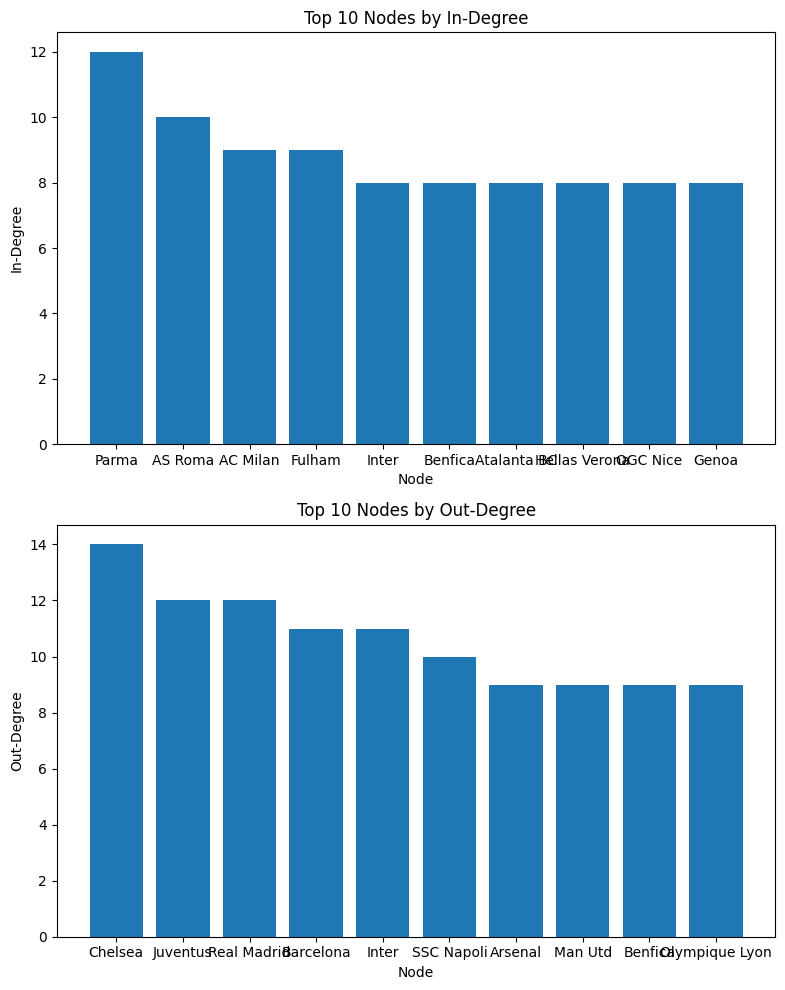

In [91]:
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

# sort the nodes based on their in-degree and out-degree and select the top 10 nodes
top_10_in_degree = sorted(in_degree, key=in_degree.get, reverse=True)[:10]
top_10_out_degree = sorted(out_degree, key=out_degree.get, reverse=True)[:10]

# create two bar plots to visualize the top 10 nodes by in-degree and out-degree
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].bar(top_10_in_degree, [in_degree[node] for node in top_10_in_degree])
ax[0].set_title("Top 10 Nodes by In-Degree")
ax[0].set_xlabel("Node")
ax[0].set_ylabel("In-Degree")
ax[1].bar(top_10_out_degree, [out_degree[node] for node in top_10_out_degree])
ax[1].set_title("Top 10 Nodes by Out-Degree")
ax[1].set_xlabel("Node")
ax[1].set_ylabel("Out-Degree")
plt.tight_layout()
plt.show()

In [99]:
G_2018 = nx.DiGraph()
with open('./2018.csv', 'r') as f:
    data = csv.reader(f)
    headers = next(data)
    for row in data:
        if not G_2018.has_node(row[1]):
            G_2018.add_node(row[1])
        if not G.has_node(row[2]):
            G_2018.add_node(row[2]) 
        if G_2018.has_edge(row[1], row[2]):
            # edge already exists, increase weight by one
            G_2018[row[1]][row[2]]['weight'] += 1
            #print(G[row[3]][row[6]]['weight'])
        else:
            # add new edge with weight 1
            G_2018.add_edge(row[1], row[2], weight = 1)

print(G_2018.number_of_nodes())
print(G_2018.number_of_edges())

275
599


In [150]:
G_2019 = nx.DiGraph()
with open('./2019.csv', 'r') as f:
    data = csv.reader(f)
    headers = next(data)
    for row in data:
        if not G_2019.has_node(row[1]):
            G_2019.add_node(row[1])
        if not G.has_node(row[2]):
            G_2019.add_node(row[2]) 
        if G_2019.has_edge(row[1], row[2]):
            # edge already exists, increase weight by one
            G_2019[row[1]][row[2]]['weight'] += 1
            #print(G[row[3]][row[6]]['weight'])
        else:
            # add new edge with weight 1
            G_2019.add_edge(row[1], row[2], weight = 1)

print(G_2019.number_of_nodes())
print(G_2019.number_of_edges())

254
580


In [151]:
G_2021 = nx.DiGraph()
with open('./2021.csv', 'r') as f:
    data = csv.reader(f)
    headers = next(data)
    for row in data:
        if not G_2021.has_node(row[1]):
            G_2021.add_node(row[1])
        if not G.has_node(row[2]):
            G_2021.add_node(row[2]) 
        if G_2021.has_edge(row[1], row[2]):
            # edge already exists, increase weight by one
            G_2021[row[1]][row[2]]['weight'] += 1
            #print(G[row[3]][row[6]]['weight'])
        else:
            # add new edge with weight 1
            G_2021.add_edge(row[1], row[2], weight = 1)

print(G_2021.number_of_nodes())
print(G_2021.number_of_edges())

283
597


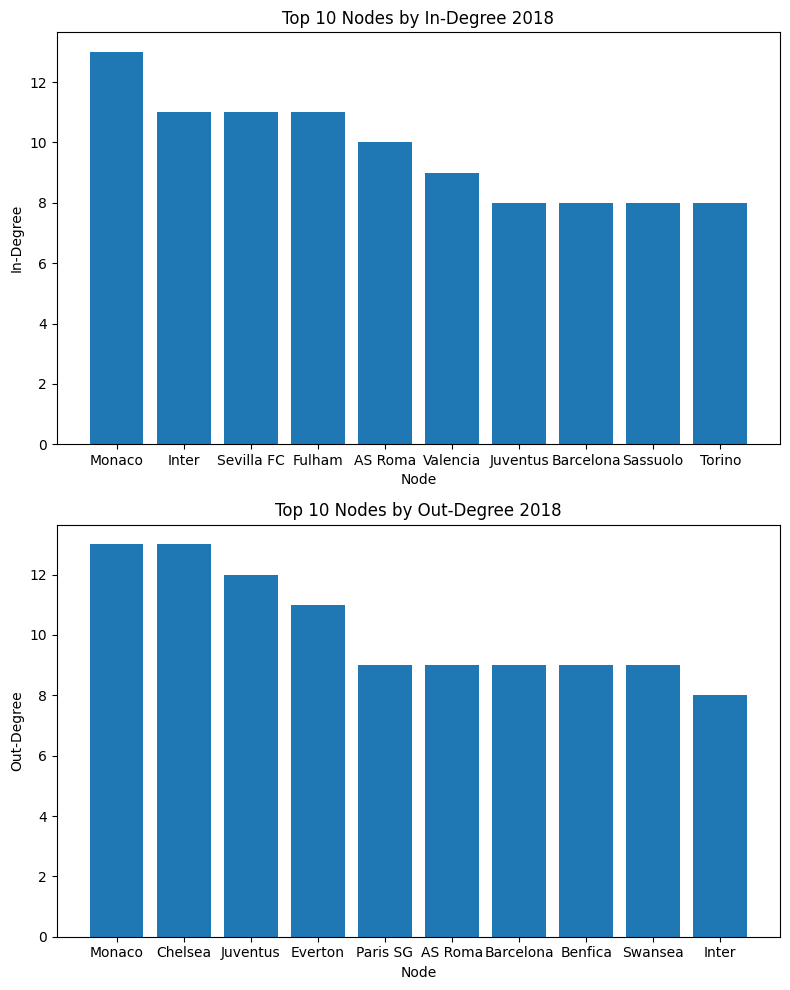

In [92]:

in_degree = dict(G_2018.in_degree())
out_degree = dict(G_2018.out_degree())

# sort the nodes based on their in-degree and out-degree and select the top 10 nodes
top_10_in_degree = sorted(in_degree, key=in_degree.get, reverse=True)[:10]
top_10_out_degree = sorted(out_degree, key=out_degree.get, reverse=True)[:10]

# create two bar plots to visualize the top 10 nodes by in-degree and out-degree
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].bar(top_10_in_degree, [in_degree[node] for node in top_10_in_degree])
ax[0].set_title("Top 10 Nodes by In-Degree 2018")
ax[0].set_xlabel("Node")
ax[0].set_ylabel("In-Degree")
ax[1].bar(top_10_out_degree, [out_degree[node] for node in top_10_out_degree])
ax[1].set_title("Top 10 Nodes by Out-Degree 2018")
ax[1].set_xlabel("Node")
ax[1].set_ylabel("Out-Degree")
plt.tight_layout()
plt.show()

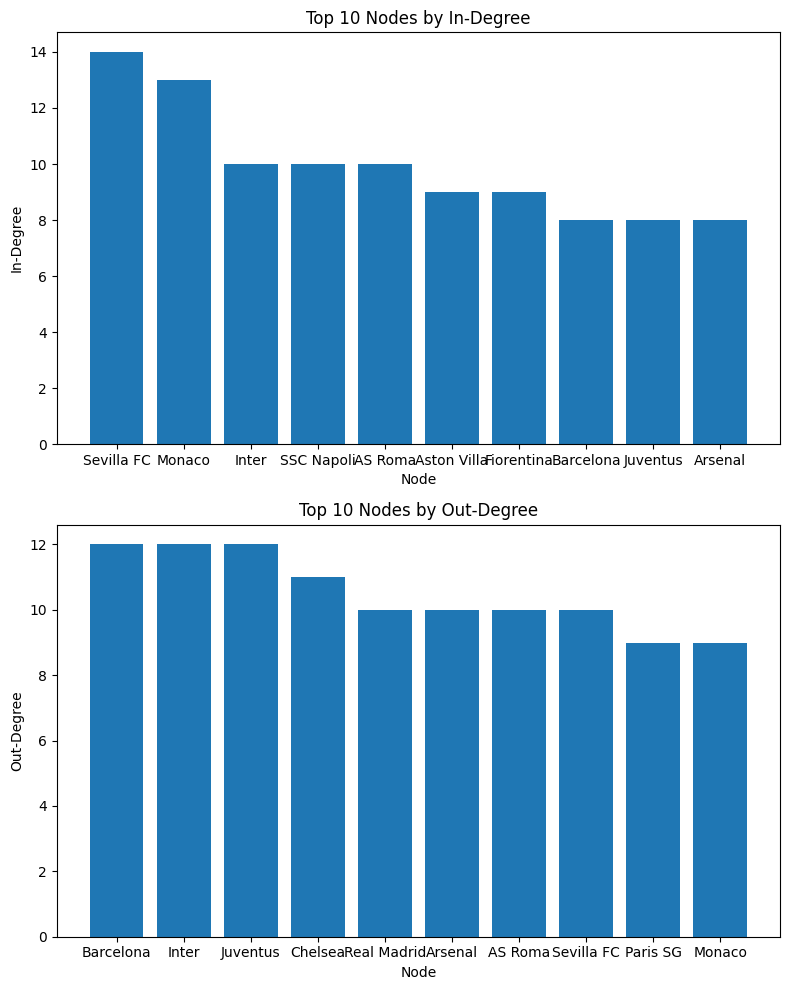

In [93]:
in_degree = dict(G_2019.in_degree())
out_degree = dict(G_2019.out_degree())

# sort the nodes based on their in-degree and out-degree and select the top 10 nodes
top_10_in_degree = sorted(in_degree, key=in_degree.get, reverse=True)[:10]
top_10_out_degree = sorted(out_degree, key=out_degree.get, reverse=True)[:10]

# create two bar plots to visualize the top 10 nodes by in-degree and out-degree
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].bar(top_10_in_degree, [in_degree[node] for node in top_10_in_degree])
ax[0].set_title("Top 10 Nodes by In-Degree")
ax[0].set_xlabel("Node")
ax[0].set_ylabel("In-Degree")
ax[1].bar(top_10_out_degree, [out_degree[node] for node in top_10_out_degree])
ax[1].set_title("Top 10 Nodes by Out-Degree")
ax[1].set_xlabel("Node")
ax[1].set_ylabel("Out-Degree")
plt.tight_layout()
plt.show()

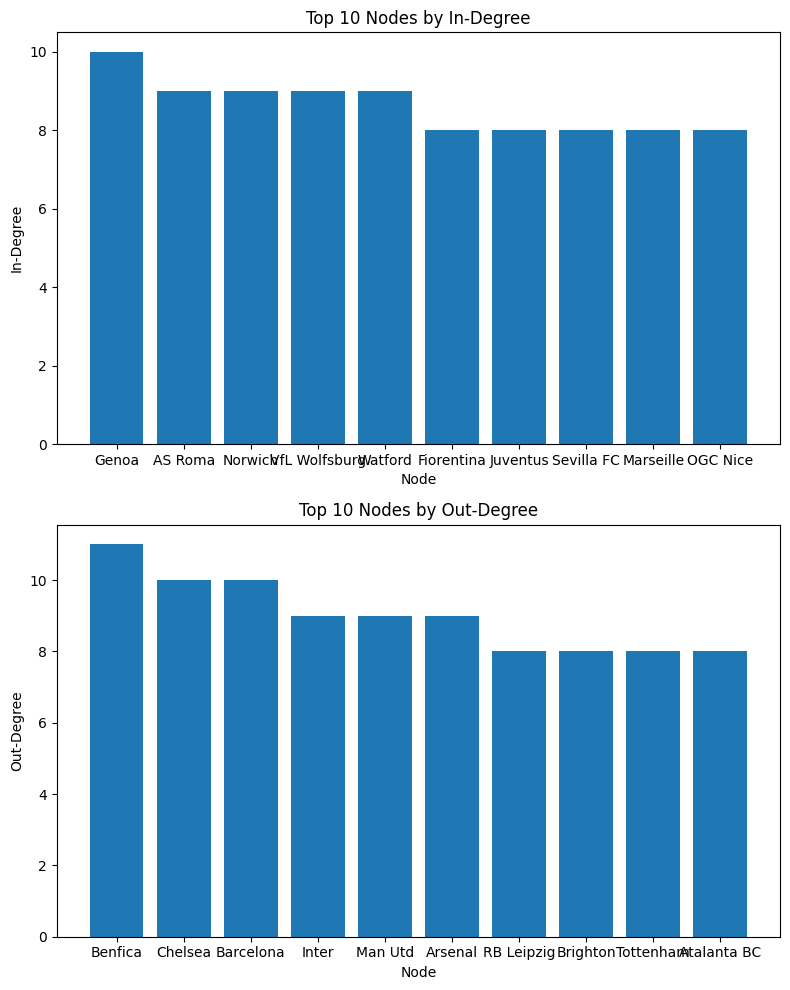

In [94]:
in_degree = dict(G_2021.in_degree())
out_degree = dict(G_2021.out_degree())

# sort the nodes based on their in-degree and out-degree and select the top 10 nodes
top_10_in_degree = sorted(in_degree, key=in_degree.get, reverse=True)[:10]
top_10_out_degree = sorted(out_degree, key=out_degree.get, reverse=True)[:10]

# create two bar plots to visualize the top 10 nodes by in-degree and out-degree
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].bar(top_10_in_degree, [in_degree[node] for node in top_10_in_degree])
ax[0].set_title("Top 10 Nodes by In-Degree")
ax[0].set_xlabel("Node")
ax[0].set_ylabel("In-Degree")
ax[1].bar(top_10_out_degree, [out_degree[node] for node in top_10_out_degree])
ax[1].set_title("Top 10 Nodes by Out-Degree")
ax[1].set_xlabel("Node")
ax[1].set_ylabel("Out-Degree")
plt.tight_layout()
plt.show()

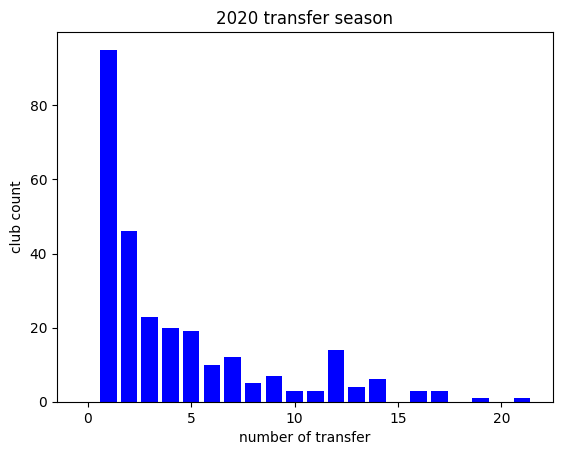

Node with the highest degree: Chelsea
Node with the lowest degree: Corinthians


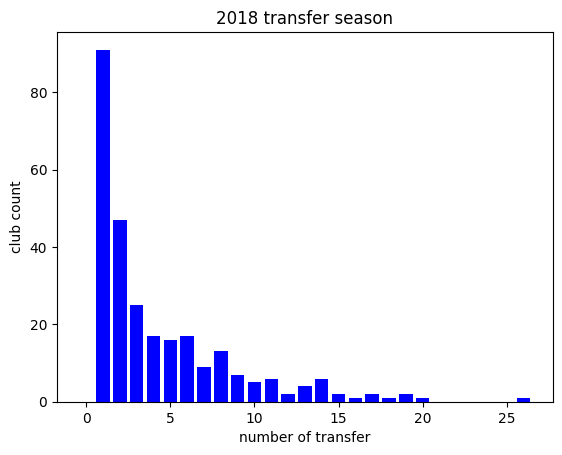

Node with the highest degree: Monaco
Node with the lowest degree: Racing Club


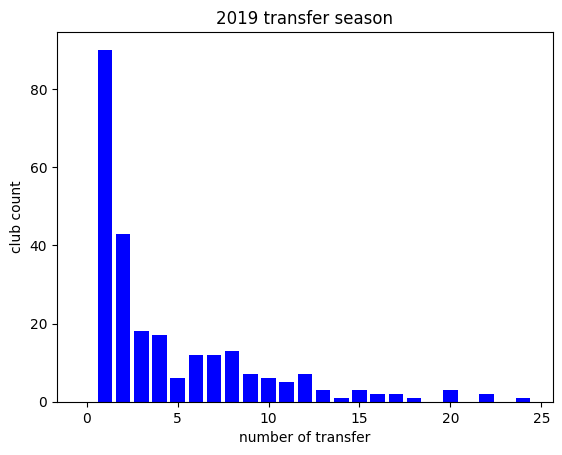

Node with the highest degree: Sevilla FC
Node with the lowest degree: SH SIPG


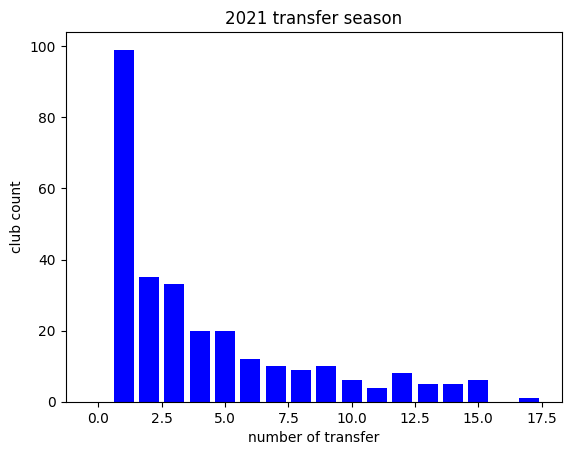

Node with the highest degree: Barcelona
Node with the lowest degree: Blackburn


In [153]:
def degree_sequence(G):
    return [d for n, d in G.degree()]

def degree_distribution(G,normalize=True):
    deg_sequence = degree_sequence(G)
    max_degree = max(deg_sequence)
    ddist = zeros((max_degree+1,))
    for d in deg_sequence:
        ddist[d] += 1
    if normalize:
        ddist = ddist/float(G.number_of_nodes())
    return ddist


ddist = degree_distribution(G,normalize=False)
plt.bar(range(len(ddist)),ddist, width=0.8, bottom=0, color='b')
plt.title('2020 transfer season')
plt.xlabel('number of transfer')
plt.ylabel('club count')
plt.show()

degrees = dict(G.degree())
max_degree_node = max(degrees, key=degrees.get)
print("Node with the highest degree:", max_degree_node)

min_degree_node = min(degrees, key=degrees.get)
print("Node with the lowest degree:", min_degree_node)


ddist = degree_distribution(G_2018,normalize=False)
plt.bar(range(len(ddist)),ddist, width=0.8, bottom=0, color='b')
plt.title('2018 transfer season')
plt.xlabel('number of transfer')
plt.ylabel('club count')
plt.show()

degrees = dict(G_2018.degree())
max_degree_node = max(degrees, key=degrees.get)
print("Node with the highest degree:", max_degree_node)

min_degree_node = min(degrees, key=degrees.get)
print("Node with the lowest degree:", min_degree_node)


ddist = degree_distribution(G_2019,normalize=False)
plt.bar(range(len(ddist)),ddist, width=0.8, bottom=0, color='b')
plt.title('2019 transfer season')
plt.xlabel('number of transfer')
plt.ylabel('club count')
plt.show()

degrees = dict(G_2019.degree())
max_degree_node = max(degrees, key=degrees.get)
print("Node with the highest degree:", max_degree_node)

min_degree_node = min(degrees, key=degrees.get)
print("Node with the lowest degree:", min_degree_node)

ddist = degree_distribution(G_2021,normalize=False)
plt.bar(range(len(ddist)),ddist, width=0.8, bottom=0, color='b')
plt.title('2021 transfer season')
plt.xlabel('number of transfer')
plt.ylabel('club count')
plt.show()

degrees = dict(G_2021.degree())
max_degree_node = max(degrees, key=degrees.get)
print("Node with the highest degree:", max_degree_node)

min_degree_node = min(degrees, key=degrees.get)
print("Node with the lowest degree:", min_degree_node)

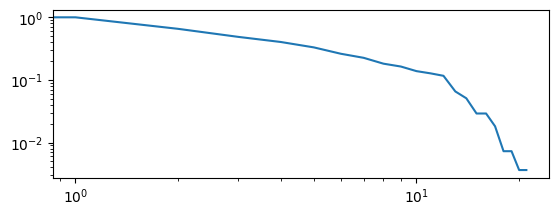

In [63]:
def cumulative_degree_distribution(G):
    ddist = degree_distribution(G)
    cdist = [ ddist[k:].sum()  for k in range(len(ddist)) ] 
    return cdist
cdist = cumulative_degree_distribution(G)
plt.subplot(212)
plt.loglog(range(len(cdist)),cdist)
plt.show()

In [97]:
for u, v, d in G.edges(data=True):
    print(u,v,d)

B. Leverkusen Chelsea {'width': 1}
B. Leverkusen Monaco {'width': 1}
B. Leverkusen Saint-Étienne {'width': 1}
Chelsea Atlético Madrid {'width': 1}
Chelsea SSC Napoli {'width': 1}
Chelsea Atalanta BC {'width': 1}
Chelsea Fulham {'width': 1}
Chelsea Arsenal {'width': 1}
Chelsea Aston Villa {'width': 1}
Chelsea AC Milan {'width': 1}
Chelsea FC Porto {'width': 1}
Chelsea Crystal Palace {'width': 1}
Chelsea Genoa {'width': 1}
Chelsea AS Roma {'width': 1}
Chelsea Granada CF {'width': 1}
Chelsea Sheff Utd {'width': 1}
Chelsea Spartak Moscow {'width': 1}
Man City Bayern Munich {'width': 1}
Man City Benfica {'width': 1}
Man City Real Sociedad {'width': 1}
Man City Sporting CP {'width': 1}
Man City Girona {'width': 1}
Bayern Munich Liverpool {'width': 1}
Bayern Munich Marseille {'width': 1}
Bayern Munich Parma {'width': 1}
Bayern Munich TSG Hoffenheim {'width': 1}
Bayern Munich PSV Eindhoven {'width': 1}
Barcelona Juventus {'width': 1}
Barcelona Wolves {'width': 1}
Barcelona Atlético Madrid {'wi

In [103]:
edge_weights = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]

edge_weights_sorted = sorted(edge_weights, key=lambda x: x[2], reverse=True)

# get the top 10 edge and node combinations based on weight
top_edges = edge_weights_sorted[:10]
#print(top_edges,'\n')
for a,b,c in top_edges:
    print(a,b,c)


Watford Udinese Calcio 4
SSC Napoli Parma 3
Sampdoria Torino 3
Barcelona Getafe 2
Juventus Miami 2
Juventus Atalanta BC 2
Juventus Genoa 2
SSC Napoli Cagliari Calcio 2
SSC Napoli Fiorentina 2
Inter Cagliari Calcio 2


In [66]:
edge_weights = [(u, v, d['weight']) for u, v, d in G_2018.edges(data=True)]

edge_weights_sorted = sorted(edge_weights, key=lambda x: x[2], reverse=True)

# get the top 10 edge and node combinations based on weight
top_edges = edge_weights_sorted[:10]
#print(top_edges,'\n')
for a,b,c in top_edges:
    print(a,b,c)


Atlético Madrid Wolves 3
Barcelona Everton 3
Monaco Huddersfield 2
Monaco Leicester 2
Juventus AC Milan 2
Juventus Genoa 2
Liverpool Bournemouth 2
SSC Napoli Parma 2
Barcelona GZ Evergrande 2
Barcelona Sevilla FC 2


In [67]:
edge_weights = [(u, v, d['weight']) for u, v, d in G_2019.edges(data=True)]

edge_weights_sorted = sorted(edge_weights, key=lambda x: x[2], reverse=True)

# get the top 10 edge and node combinations based on weight
top_edges = edge_weights_sorted[:10]
#print(top_edges,'\n')
for a,b,c in top_edges:
    print(a,b,c)


Juventus Genoa 4
Inter Genoa 3
Sevilla FC CD Leganés 3
Sassuolo Fiorentina 3
Barcelona Celta de Vigo 2
Inter Parma 2
Man Utd Inter 2
LOSC Lille Olympique Lyon 2
Paris SG Monaco 2
FC Porto Atlético Madrid 2


In [68]:
edge_weights = [(u, v, d['weight']) for u, v, d in G_2021.edges(data=True)]

edge_weights_sorted = sorted(edge_weights, key=lambda x: x[2], reverse=True)

# get the top 10 edge and node combinations based on weight
top_edges = edge_weights_sorted[:10]
#print(top_edges,'\n')
for a,b,c in top_edges:
    print(a,b,c)


Man City Barcelona 3
Inter Benfica 2
Inter Genoa 2
Chelsea AC Milan 2
Juventus Atalanta BC 2
Juventus Tottenham 2
RB Leipzig Bayern Munich 2
Arsenal Marseille 2
Liverpool Fulham 2
AS Roma Marseille 2


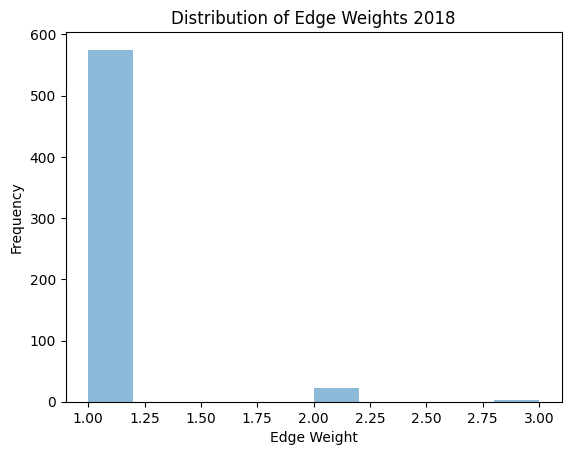

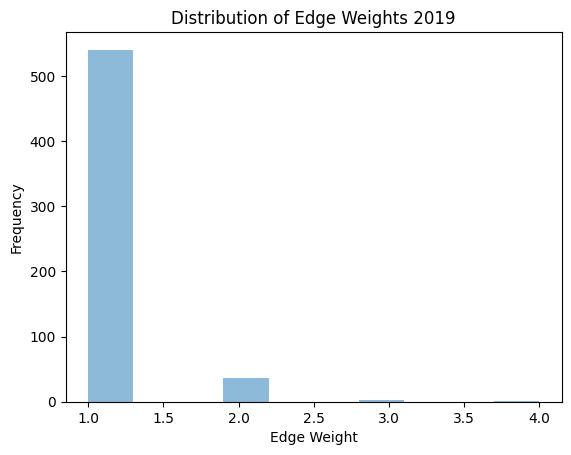

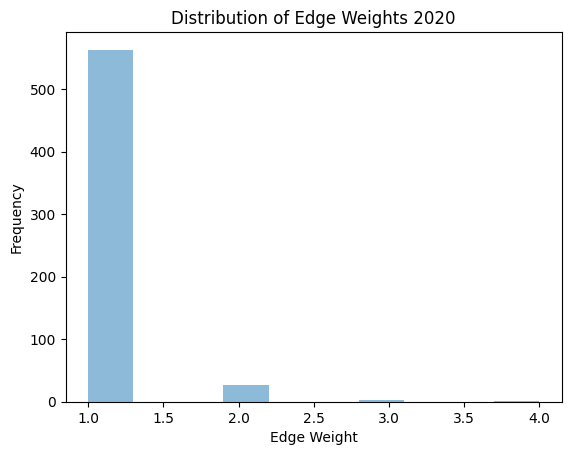

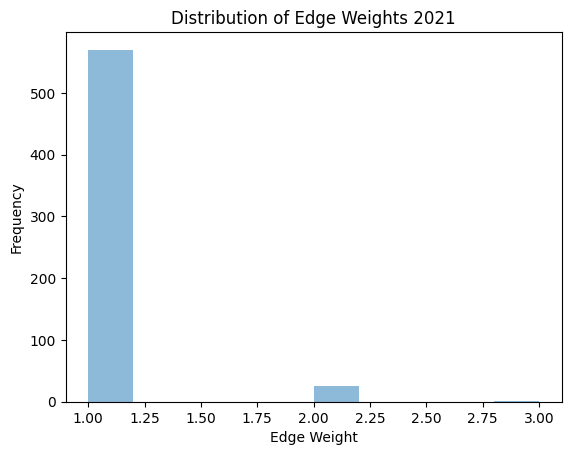

In [69]:
weights = [d['weight'] for u, v, d in G_2018.edges(data=True)]

# create a histogram of the edge weights
plt.hist(weights, bins=10, alpha=0.5)
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Edge Weights 2018')
plt.show()


weights = [d['weight'] for u, v, d in G_2019.edges(data=True)]

# create a histogram of the edge weights
plt.hist(weights, bins=10, alpha=0.5)
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Edge Weights 2019')
plt.show()

weights = [d['weight'] for u, v, d in G.edges(data=True)]

# create a histogram of the edge weights
plt.hist(weights, bins=10, alpha=0.5)
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Edge Weights 2020')
plt.show()

weights = [d['weight'] for u, v, d in G_2021.edges(data=True)]

# create a histogram of the edge weights
plt.hist(weights, bins=10, alpha=0.5)
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Edge Weights 2021')
plt.show()

In [66]:
print(df1.shape)
print(df1.index)
print(df1.columns)
print(df1.info())
print(df1.count())


(625, 2)
RangeIndex(start=0, stop=625, step=1)
Index(['club_from', 'club_to'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   club_from  625 non-null    object
 1   club_to    625 non-null    object
dtypes: object(2)
memory usage: 9.9+ KB
None
club_from    625
club_to      625
dtype: int64


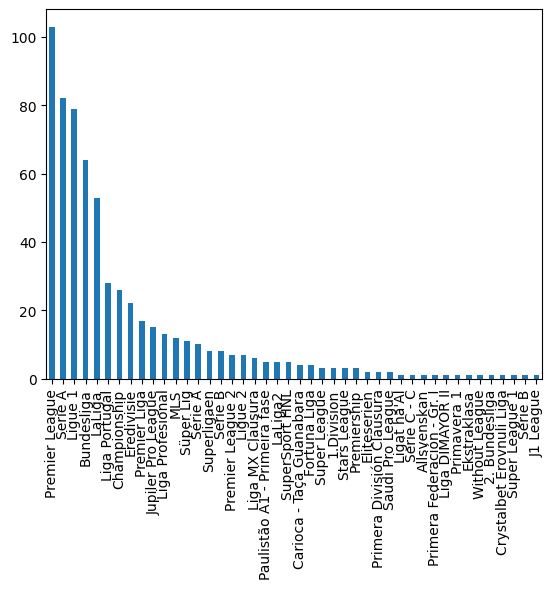

In [185]:

plot = df['league_from'].value_counts().plot(kind='bar')

plt.show(plot)

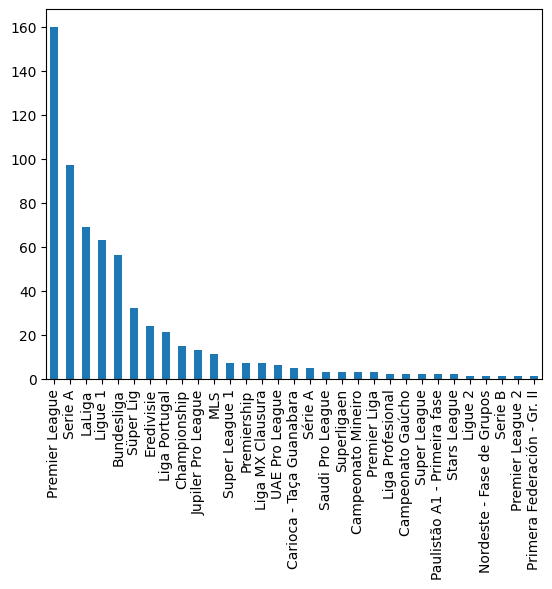

In [184]:
plot = df['league_to'].value_counts().plot(kind='bar')

plt.show(plot)

In [17]:
G_Data = nx.MultiGraph()
with open('./data.csv', 'r') as f:
    data = csv.reader(f)
    headers = next(data)
    for row in tqdm(data):
        G_Data.add_node(row[3])
        G_Data.add_node(row[6]) 
        if G_Data.has_edge(row[3], row[6]):
            G_Data.add_edge(row[3], row[6], weight = 1)
        else: 
            G_Data.add_edge(row[3], row[6], weight = 1)
n = G_Data.number_of_nodes()

625it [00:00, 121593.77it/s]


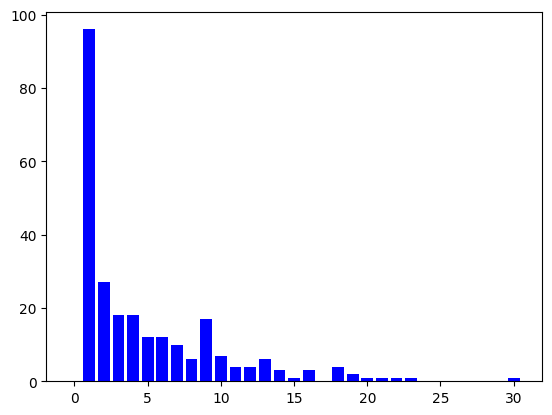

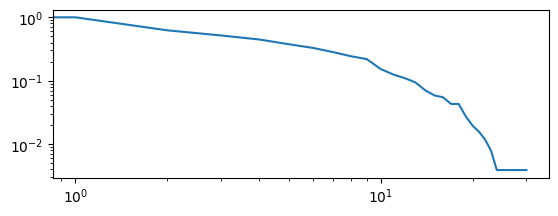

In [114]:
def degree_sequence(G):
    return [d for n, d in G.degree()]

def degree_distribution(G,normalize=True):
    deg_sequence = degree_sequence(G)
    max_degree = max(deg_sequence)
    ddist = zeros((max_degree+1,))
    for d in deg_sequence:
        ddist[d] += 1
    if normalize:
        ddist = ddist/float(G.number_of_nodes())
    return ddist

ddist = degree_distribution(G_Data,normalize=False)
plt.bar(range(len(ddist)),ddist, width=0.8, bottom=0, color='b')
plt.show()

def cumulative_degree_distribution(G):
    ddist = degree_distribution(G)
    cdist = [ ddist[k:].sum()  for k in range(len(ddist)) ] 
    return cdist
cdist = cumulative_degree_distribution(G_Data)
plt.subplot(212)
plt.loglog(range(len(cdist)),cdist)
plt.show()

In [73]:
def centrality_vector(G,d):
    thenodes = list(G.nodes())
    v = numpy.zeros((G.number_of_nodes(),))
    for i,u in enumerate(thenodes):
        v[i] = d[u]
    return v

In [81]:
def print_top(G,v, num=20):
    thenodes = list(G.nodes())
    idx_list = [(i,v[i]) for i in range(len(v))]
    idx_list = sorted(idx_list, key = lambda x: x[1], reverse=True)
    for i in range(min(num,len(idx_list))):
        nidx, score = idx_list[i]
        print('  %i. %s (%1.4f)' % (i+1,thenodes[nidx],score))
        #print ('  %i. %s' % (i+1,G.node_object(idx)))

In [158]:
print('Degree Centrality with network x')
deg_cent = nx.degree_centrality(G)
v = centrality_vector(G,deg_cent)
print_top(G,v)

Degree Centrality with network x
  1. Chelsea (0.0766)
  2. Inter (0.0693)
  3. Juventus (0.0620)
  4. Benfica (0.0620)
  5. AS Roma (0.0620)
  6. Arsenal (0.0584)
  7. AC Milan (0.0584)
  8. Sevilla FC (0.0584)
  9. Barcelona (0.0511)
  10. Atlético Madrid (0.0511)
  11. Man Utd (0.0511)
  12. FC Porto (0.0511)
  13. OGC Nice (0.0511)
  14. Brighton (0.0511)
  15. Wolves (0.0474)
  16. Ajax (0.0474)
  17. Olympique Lyon (0.0474)
  18. Parma (0.0474)
  19. Man City (0.0438)
  20. SSC Napoli (0.0438)


In [159]:
print('Eigenvector Centrality (by NetworkX):')
eig_cent = nx.eigenvector_centrality(G,weight='weight')
v = centrality_vector(G,eig_cent)
print_top(G,v)

Eigenvector Centrality (by NetworkX):
  1. Hellas Verona (0.3079)
  2. Inter (0.2889)
  3. Cagliari Calcio (0.2708)
  4. Genoa (0.2485)
  5. AS Roma (0.2391)
  6. Fulham (0.2140)
  7. Parma (0.2093)
  8. Fiorentina (0.1896)
  9. Paris SG (0.1846)
  10. Chelsea (0.1768)
  11. Sassuolo (0.1518)
  12. Atalanta BC (0.1331)
  13. AC Milan (0.1253)
  14. Aston Villa (0.1178)
  15. Rennes (0.1170)
  16. B. Leverkusen (0.1149)
  17. OGC Nice (0.1111)
  18. Benevento (0.1073)
  19. Sampdoria (0.1067)
  20. Torino (0.1065)


In [160]:
print('Betweenness Centrality')
bet_cent = nx.betweenness_centrality(G,weight='weight')
cent = centrality_vector(G,bet_cent)
print_top(G,cent)

Betweenness Centrality
  1. Chelsea (0.0620)
  2. Sevilla FC (0.0478)
  3. Inter (0.0437)
  4. Atalanta BC (0.0333)
  5. Juventus (0.0333)
  6. Arsenal (0.0328)
  7. Benfica (0.0321)
  8. Tottenham (0.0314)
  9. Atlético Madrid (0.0310)
  10. AS Roma (0.0309)
  11. Paris SG (0.0294)
  12. OGC Nice (0.0286)
  13. AC Milan (0.0285)
  14. Southampton (0.0281)
  15. Man Utd (0.0274)
  16. Ajax (0.0270)
  17. Fenerbahce (0.0259)
  18. Liverpool (0.0241)
  19. FC Porto (0.0237)
  20. Sporting CP (0.0233)


In [79]:
def index_of_max(v):
    return numpy.where(v == max(v))[0]

In [123]:
#largest_cc = max(nx.connected_components(G), key=len)
#print('Giant Component \t ', len(largest_cc))

num_N = G.number_of_nodes()
print(num_N)

connected_components = list(nx.strongly_connected_components(G))

# get the size of each connected component
component_sizes = [len(c) for c in connected_components]
print(component_sizes)
largest_component_index = component_sizes.index(max(component_sizes))

largest_component = connected_components[largest_component_index]
giant_component = G.subgraph(largest_component)

n = giant_component.number_of_nodes()
print(n)

G_undirected = G.to_undirected(False)

connected_components = list(nx.connected_components(G_undirected))
component_sizes = [len(c) for c in connected_components]
print(component_sizes)
largest_component_index = component_sizes.index(max(component_sizes))
largest_component = connected_components[largest_component_index]
giant_component = G_undirected.subgraph(largest_component)

n = giant_component.number_of_nodes()
print(n)

275
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 110, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
110
[257, 2, 2, 2, 2, 3, 2, 2, 3]
257


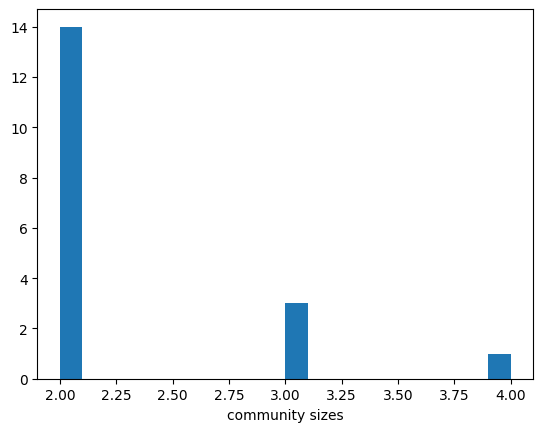

In [134]:
G2 = copy.deepcopy(G_undirected)
for component in list(nx.connected_components(G2)):
    if len(component)<2:
        for node in component:
            G2.remove_node(node)

for u,v in G2.edges():
    if G2[u][v]['weight'] <= 1:
        G2.remove_edge(u,v)
empty_nodes = [node for node in G2.nodes() if G2.degree() == 0]
for i in empty_nodes:
    G2.remove_nodes_from(i)
cset = list(nx_comm.label_propagation_communities(G2))
comm_sizes = []
for u in cset:
    if len(u) >=2:
        comm_sizes.append(len(u))    
plt.hist(comm_sizes,20)
plt.xlabel('community sizes')
plt.show()

In [157]:
n = G.number_of_nodes()
print(n)
m = G.number_of_edges()
print(m)
avg_degree= 2*m/n
cluster_coeff = nx.average_clustering(G)
print(avg_degree)
print(cluster_coeff)

275
592
4.305454545454546
0.01817886898485925


In [181]:
cliques = list(nx.find_cliques(G_undirected))

# print the list of maximal cliques
print("Maximal cliques:")
#print(cliques)

# find the size of the largest maximal clique
clique_number = nx.graph_clique_number(G_undirected)-1

# print the size of the largest maximal clique
print("Size of largest maximal clique:")
#print(clique_number)
cliques_2020=[]
for clique in cliques:
    if len(clique) == clique_number:
        #print(clique)
        cliques_2020.append(clique)


Maximal cliques:
Size of largest maximal clique:


In [175]:
G_undirected_2018 = G_2018.to_undirected(False)
cliques = list(nx.find_cliques(G_undirected_2018))

# print the list of maximal cliques
print("Maximal cliques:")
#print(cliques)

# find the size of the largest maximal clique
clique_number = nx.graph_clique_number(G_undirected_2018)-1

# print the size of the largest maximal clique
print("Size of largest maximal clique:")
#print(clique_number)
cliques_2018=[]
for clique in cliques:
    if len(clique) == clique_number:
        #print(clique)
        cliques_2018.append(clique)

Maximal cliques:
Size of largest maximal clique:


In [176]:
G_undirected_2019 = G_2019.to_undirected(False)
cliques = list(nx.find_cliques(G_undirected_2019))

# print the list of maximal cliques
print("Maximal cliques:")
#print(cliques)

# find the size of the largest maximal clique
clique_number = nx.graph_clique_number(G_undirected_2019)-1

# print the size of the largest maximal clique
print("Size of largest maximal clique:")
#print(clique_number)
cliques_2019=[]
for clique in cliques:
    if len(clique) == clique_number:
        #print(clique)
        cliques_2019.append(clique)

Maximal cliques:
Size of largest maximal clique:


In [171]:
G_undirected_2021 = G_2021.to_undirected(False)
cliques = list(nx.find_cliques(G_undirected_2021))

# print the list of maximal cliques
print("Maximal cliques:")
#print(cliques)

# find the size of the largest maximal clique
clique_number = nx.graph_clique_number(G_undirected_2021)-1

# print the size of the largest maximal clique
print("Size of largest maximal clique:")
#print(clique_number)
cliques_2021=[]
for clique in cliques:
    if len(clique) == clique_number:
        #print(clique)
        cliques_2021.append(clique)



Maximal cliques:
Size of largest maximal clique:


In [190]:


for sublist1 in cliques_2018:
    for sublist2 in cliques_2019:
        if set(sublist1) == set(sublist2):
            print("List items", sublist1, "and", sublist2, "are similar. 2019")

for sublist1 in cliques_2018:
    for sublist2 in cliques_2020:
        if set(sublist1) == set(sublist2):
            print("List items", sublist1, "and", sublist2, "are similar.2020")



for sublist1 in cliques_2018:
    for sublist2 in cliques_2021:
        if set(sublist1) == set(sublist2):
            print("List items", sublist1, "and", sublist2, "are similar.2021")

List items ['AS Roma', 'Sassuolo', 'Fiorentina'] and ['AS Roma', 'Sassuolo', 'Fiorentina'] are similar. 2019
List items ['AS Roma', 'Sassuolo', 'Inter'] and ['Sassuolo', 'Inter', 'AS Roma'] are similar.2020
List items ['AS Roma', 'Sassuolo', 'Fiorentina'] and ['Sassuolo', 'Fiorentina', 'AS Roma'] are similar.2020


In [191]:


for sublist1 in cliques_2019:
    for sublist2 in cliques_2020:
        if set(sublist1) == set(sublist2):
            print("List items", sublist1, "and", sublist2, "are similar. 2020")

for sublist1 in cliques_2019:
    for sublist2 in cliques_2021:
        if set(sublist1) == set(sublist2):
            print("List items", sublist1, "and", sublist2, "are similar. 21")


List items ['Chelsea', 'AS Roma', 'Arsenal'] and ['Chelsea', 'AS Roma', 'Arsenal'] are similar. 2020
List items ['Chelsea', 'AS Roma', 'RB Leipzig'] and ['Chelsea', 'AS Roma', 'RB Leipzig'] are similar. 2020
List items ['E. Frankfurt', 'Real Madrid', 'AC Milan'] and ['E. Frankfurt', 'AC Milan', 'Real Madrid'] are similar. 2020
List items ['AS Roma', 'Sassuolo', 'Fiorentina'] and ['Sassuolo', 'Fiorentina', 'AS Roma'] are similar. 2020
List items ['Sevilla FC', 'Real Madrid', 'AC Milan'] and ['Sevilla FC', 'AC Milan', 'Real Madrid'] are similar. 2020


In [189]:
for sublist1 in cliques_2020:
    for sublist2 in cliques_2021:
        #print(sublist1, sublist2)
        if set(sublist1) == set(sublist2):
            print("List items", sublist1, "and", sublist2, "are similar.")




In [149]:
G_undirected_symmetric = G.to_undirected(True)
cliques = list(nx.find_cliques(G_undirected_symmetric))

# print the list of maximal cliques
print("Maximal cliques:")
#print(cliques)

# find the size of the largest maximal clique
clique_number = nx.graph_clique_number(G_undirected_symmetric)

# print the size of the largest maximal clique
print("Size of largest maximal clique:")
#print(clique_number)

for clique in cliques:
    if len(clique) == clique_number:
        print(clique)

Maximal cliques:
Size of largest maximal clique:
['Sheff Utd', 'West Brom']
['AC Milan', 'E. Frankfurt']
['AC Milan', 'Sevilla FC']
['Barcelona', 'Juventus']
['River Plate', 'CA Colon']
['SC Braga', 'Sporting CP']
['Arsenal', 'Atlético Madrid']
["Bor. M'gladbach", 'Toulouse']
['E. Frankfurt', 'TSG Hoffenheim']
['Brighton', 'Legia Warszawa']
['Udinese Calcio', 'Juventus']
['Benfica', 'Tottenham']
['Benfica', 'Man City']
['Fulham', 'G. Bordeaux']
['Southampton', 'Tottenham']
['Bayern Munich', 'Marseille']
['Partizan', 'Man City U23']
['1. FC Köln', 'Hertha BSC']
['SSC Napoli', 'LOSC Lille']
['Saint-Étienne', 'Olympiacos']
['Inter', 'Cagliari Calcio']
['Inter', 'Parma']
['Inter', 'Genoa']


In [141]:
parts = community.best_partition(G)
values = [parts.get(node) for node in G.nodes()]

AttributeError: module 'community' has no attribute 'best_partition'

 2.03 +/- 0.36


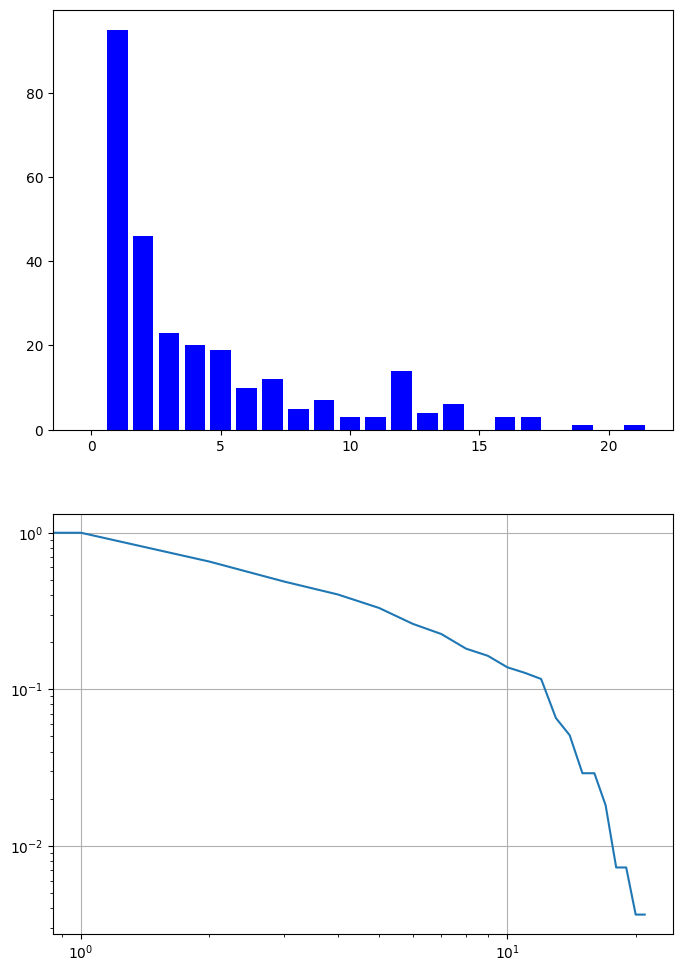

In [108]:
def calc_powerlaw(G,kmin):
    ddist = degree_distribution(G,normalize=False)
    cdist = cumulative_degree_distribution(G)
    k = arange(len(ddist))

   
  
    
    
    tmp_val = 0
    exponent_val=-1
    tmp=[]
   
        
    for x in ddist:
        if x >= kmin:
            tmp_val += log(float(x) / (kmin - .5))  
            tmp.append(x)      
            
    tmp_val = tmp_val**exponent_val
    
    n=float(len(tmp))
    #print(n)
    #n =float(len(G.nodes()))
    #print(type(n))
    alpha = 1 + n * (tmp_val)# calculate using Newman (8.6)!
    sigma = ((alpha-1)/sqrt((n)))# calculate using Newman (8.7)!
    print( ' %1.2f +/- %1.2f' % (alpha,sigma) )

    plt.figure(figsize=(8,12))
    plt.subplot(211)
    #plt.bar(ddist,k, width=0.8, bottom=0, color='b') # replace xvalues and barheights!
    plt.bar(range(len(ddist)),ddist, width=0.8, bottom=0, color='b')    

    plt.subplot(212)
    plt.loglog(range(len(cdist)),cdist) # replace xvalues and yvalues!
    plt.grid(True)


calc_powerlaw(G,9)

In [186]:
#country Network
G_country = nx.MultiGraph()
with open('./data.csv', 'r') as f:
    data = csv.reader(f)
    headers = next(data)
    for row in data:
        G_country.add_node(row[1])
        G_country.add_node(row[4]) 
        if  G_country.has_edge(row[1], row[4]):
            G_country.add_edge(row[1], row[4], weight = 1)
        else: 
            G_country.add_edge(row[1], row[4], weight = 1)
n = G_country.number_of_nodes()

In [155]:
print(nx.is_isomorphic(G_2018, G_2019))  # no weights considered
print(nx.is_isomorphic(G_2018, G_2020)) # no weights considered
print(nx.is_isomorphic(G_2018, G_2021))  # no weights considered

print(nx.is_isomorphic(G_2019, G_2020))  # no weights considered
print(nx.is_isomorphic(G_2019, G_2021)) # no weights considered

print(nx.is_isomorphic(G_2020, G_2021))  # no weights considered





False
False
False
False
False
False


In [156]:
print(nx.could_be_isomorphic(G_2018, G_2019))  # no weights considered
print(nx.could_be_isomorphic(G_2018, G_2020)) # no weights considered
print(nx.could_be_isomorphic(G_2018, G_2021))  # no weights considered

print(nx.could_be_isomorphic(G_2019, G_2020))  # no weights considered
print(nx.could_be_isomorphic(G_2019, G_2021)) # no weights considered

print(nx.could_be_isomorphic(G_2020, G_2021))

False
False
False
False
False
False


In [162]:
neighbors_of_bar = list(G.neighbors('Barcelona'))
print(neighbors_of_bar)
neighbors_of_psg = list(G.neighbors('Paris SG'))
print(neighbors_of_psg)

['Juventus', 'Wolves', 'Atlético Madrid', 'Sevilla FC', 'Getafe', 'Benfica', 'AS Roma', 'OGC Nice', 'Inter', 'Paris SG', 'PAOK Salonika']
['Bor. Dortmund', 'Man Utd', 'Fulham', 'Bayern Munich', 'Saint-Étienne', 'Chelsea']


In [187]:
G_country_visual = Network(height='900px', width='90%', bgcolor='white', heading='Country Mapping', notebook=True, directed=True)
G_country_visual.from_nx(G_country)

G_country_visual.show_buttons()
#G_country_visual.toggle_physics(False)
G_country_visual.show("example-country.html")


example-country.html


In [82]:
g_di = Network(height='900px', width='90%', bgcolor='white', heading='Football transfers', notebook=True, directed=True)
g_di.from_nx(G)
g_di.show_buttons()
g_di.show("example-di.html")

example-di.html


In [42]:
g_new = Network(height='900px', width='90%', bgcolor='white', heading='Football transfers', notebook=True, directed=True)
g_new.from_nx(G_Data, show_edge_weights=True)
g_new.show_buttons()
g_new.show("example.html")

example.html
